<a href="https://colab.research.google.com/github/Kryptera-K/BMY-Bollinger-Lower-Band-Reclaim-Strategy/blob/main/BMY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BMY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BMY_clean.csv", index=False)
df

/tmp/ipython-input-2860748116.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,23.440102,23.599248,23.144542,23.371895,3568588
2000-01-04,21.666744,22.212390,21.439390,22.144185,10592082
2000-01-05,21.527937,22.007350,21.368133,21.916034,7222700
2000-01-06,21.824711,21.938857,21.276810,21.550760,7321988
2000-01-07,25.020821,25.386087,22.372632,22.463949,10913586
...,...,...,...,...,...
2025-12-22,54.660000,54.820000,54.040001,54.139999,25146300
2025-12-23,54.279999,54.779999,54.009998,54.660000,16579400
2025-12-24,54.709999,54.750000,54.200001,54.410000,10038100


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2

# -------------------------
# Indicator Functions
# -------------------------

def bb_open_above_lower_after_below(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return (df['Open'] > df['BB_Lower']) & (df['Open'].shift(shift) < df['BB_Lower'].shift(shift))


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df


def piercing_line(df):
    prev_close = df['Close'].shift(1)
    prev_open = df['Open'].shift(1)
    return (prev_close < prev_open) & \
           (df['Close'] > df['Open']) & \
           (df['Open'] < prev_close) & \
           (df['Close'] > (prev_open + prev_close)/2)



# -------------------------
# Entry conditions
# -------------------------

df["BB_Open_Above_Lower_after_Below"] = bb_open_above_lower_after_below(df)

# -------------------------
# Exit conditions
# -------------------------

df["Piercing_Line"] = piercing_line(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BB_Open_Above_Lower_after_Below',
]
exit_conditions = [
    'Piercing_Line',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-12-29 00:00:00
Period                                6537 days 00:00:00
Start Value                                     100000.0
End Value                                  253187.523507
Total Return [%]                              153.187524
Benchmark Return [%]                          133.785059
Max Gross Exposure [%]                             100.0
Total Fees Paid                             34645.311667
Max Drawdown [%]                               38.729139
Max Drawdown Duration                 2498 days 00:00:00
Total Trades                                          91
Total Closed Trades                                   91
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   54.945055
Best Trade [%]                                 18.294126
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-29 00:00:00
Period                         6537 days 00:00:00
Start Value                              100000.0
End Value                           233785.059452
Total Return [%]                       133.785059
Benchmark Return [%]                   133.785059
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        70.370732
Max Drawdown Duration          3079 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      133785.059452
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-110804317.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


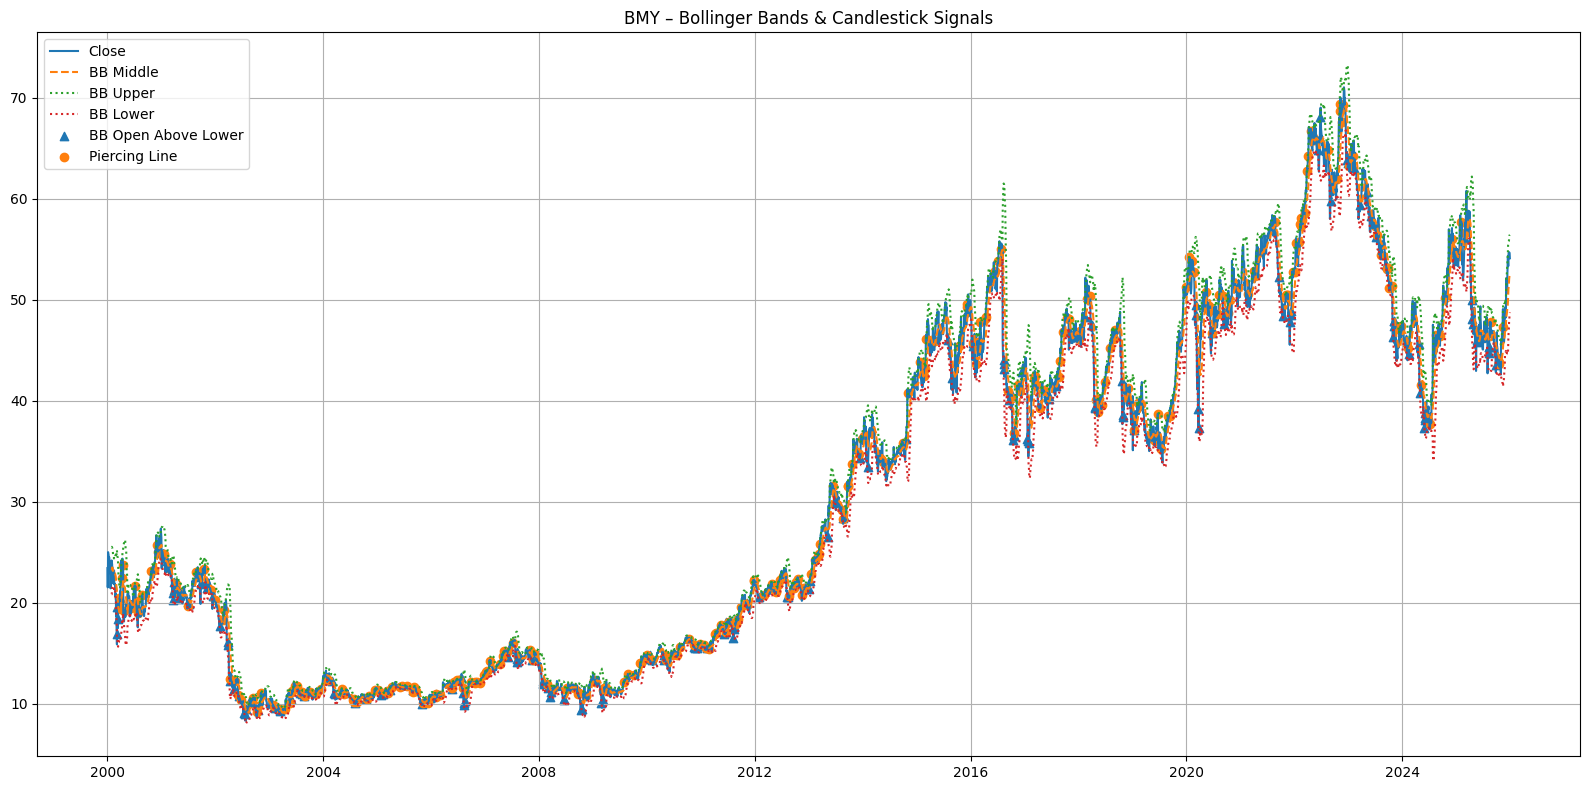

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "BMY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(
    symbol,
    start=start_date,
    end=end_date,
    interval=interval,
    multi_level_index=False
)

# -------------------------
# Parameters
# -------------------------
BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2

# -------------------------
# Indicator Functions
# -------------------------
def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    rolling_std = df['Close'].rolling(window=period).std()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * rolling_std
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * rolling_std
    return df

def bb_open_above_lower_after_below(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return (
        (df['Open'] > df['BB_Lower']) &
        (df['Open'].shift(shift) < df['BB_Lower'].shift(shift))
    )

def piercing_line(df):
    prev_close = df['Close'].shift(1)
    prev_open = df['Open'].shift(1)

    return (
        (prev_close < prev_open) &
        (df['Close'] > df['Open']) &
        (df['Open'] < prev_close) &
        (df['Close'] > (prev_open + prev_close) / 2)
    )

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_bollinger_bands(df)
df['BB_Open_Above_Lower'] = bb_open_above_lower_after_below(df)
df['Piercing_Line'] = piercing_line(df)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(16, 8))

# Price
plt.plot(df.index, df['Close'], label='Close')

# Bollinger Bands
plt.plot(df.index, df['BB_MA'], linestyle='--', label='BB Middle')
plt.plot(df.index, df['BB_Upper'], linestyle=':', label='BB Upper')
plt.plot(df.index, df['BB_Lower'], linestyle=':', label='BB Lower')

# Signals
plt.scatter(
    df.index[df['BB_Open_Above_Lower']],
    df['Close'][df['BB_Open_Above_Lower']],
    marker='^',
    label='BB Open Above Lower'
)

plt.scatter(
    df.index[df['Piercing_Line']],
    df['Close'][df['Piercing_Line']],
    marker='o',
    label='Piercing Line'
)

plt.title(f"{symbol} – Bollinger Bands & Candlestick Signals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
